# Árbol De Clasificación


Los árboles de regresión son el subtipo de árboles de predicción que se aplica cuando la variable respuesta es categórica.  
  
Para construir un árbol de clasificación, se emplea el mismo método recursive binary splitting descrito en los árboles de regresión. Sin embargo, como la variable respuesta en cualitativa, no se puede emplear el RSS como criterio de selección de las divisiones óptimas. Existen varias alternativas, todas ellas con el objetivo de encontrar nodos lo más puros/homogéneos posible. Las más empleadas son:  
* CLASSIFICATION ERROR RATE.  
* GINI INDEX.  
* INFORMATION GAIN: CROSS ENTROPY.  
* CHI-SQUARE.  
  
  
 

# Datos

In [1]:
import pandas as pd
import numpy as np

In [2]:
carseats = pd.read_csv('Carseats.csv')
datos = carseats.iloc[:,1:]
datos.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


El set de datos Carseats, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.  
Como Sales es una variable continua y el objetivo del estudio es clasificar las tiendas según si venden mucho o poco, se crea una nueva variable binaria (0, 1) llamada ventas_altas.

In [3]:
# Ponemos a ventas mayores a 8 igual a 0 y menores iguales a 1
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
data = datos.drop(columns = 'Sales')
data.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ventas_altas
0,138,73,11,276,120,Bad,42,17,Yes,Yes,0
1,111,48,16,260,83,Good,65,10,Yes,Yes,0
2,113,35,10,269,80,Medium,59,12,Yes,Yes,0
3,117,100,4,466,97,Medium,55,14,Yes,Yes,1
4,141,64,3,340,128,Bad,38,13,Yes,No,1


# Ajuste Del Modelo

Se ajusta un árbol de clasificación empleando como variable respuesta ventas_altas y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros max_depth=5 y criterion='gini', el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.

A diferencia del ejemplo anterior, en estos datos hay variables categóricas por lo que, antes de entrenar el modelo, es necesario aplicar one-hot-encoding. Puede encontrarse una descripción más detallada de este proceso en Machine learning con Python y Scikit-learn.

## División de los datos en train y test

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns = 'ventas_altas'),
    data['ventas_altas'],
    random_state = 123)

## Separación de columnas numéricas y categóricas

In [6]:
# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

In [7]:
cat_cols # Columnas categóricas

['ShelveLoc', 'Urban', 'US']

In [8]:
numeric_cols # Columnas numéricas

['CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'Age',
 'Education']

## One-hot-encoding

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='passthrough')

In [11]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ShelveLoc', 'Urban', 'US'])])

In [12]:
# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [13]:
X_train.head(3)

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
170,128,39,12,356,118,Medium,71,10,Yes,Yes
297,118,83,13,276,104,Bad,75,10,Yes,Yes
148,110,119,0,384,97,Medium,72,14,No,Yes


In [14]:
X_train_prep

array([[  0.,   0.,   1., ..., 118.,  71.,  10.],
       [  1.,   0.,   0., ..., 104.,  75.,  10.],
       [  0.,   0.,   1., ...,  97.,  72.,  14.],
       ...,
       [  0.,   1.,   0., ..., 139.,  60.,  15.],
       [  0.,   0.,   1., ..., 121.,  66.,  14.],
       [  0.,   0.,   1., ..., 162.,  57.,  17.]])

El resultado devuelto por ColumnTransformer es un numpy array , por lo que se pierden los
nombres de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras
el preprocesado en formato dataframe . Por defecto, OneHotEncoder ordena las nuevas
columnas de izquierda a derecha por orden alfabético.

In [33]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         300 non-null    float64
 1   Income            300 non-null    float64
 2   Advertising       300 non-null    float64
 3   Population        300 non-null    float64
 4   Price             300 non-null    float64
 5   Age               300 non-null    float64
 6   Education         300 non-null    float64
 7   ShelveLoc_Bad     300 non-null    float64
 8   ShelveLoc_Good    300 non-null    float64
 9   ShelveLoc_Medium  300 non-null    float64
 10  Urban_No          300 non-null    float64
 11  Urban_Yes         300 non-null    float64
 12  US_No             300 non-null    float64
 13  US_Yes            300 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


## Creación Del Modelo

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(max_depth = 5,
                                criterion = 'gini',
                                random_state = 123)
# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

## Visualización Del Árbol

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

Profundidad del árbol: 5
Número de nodos terminales: 23


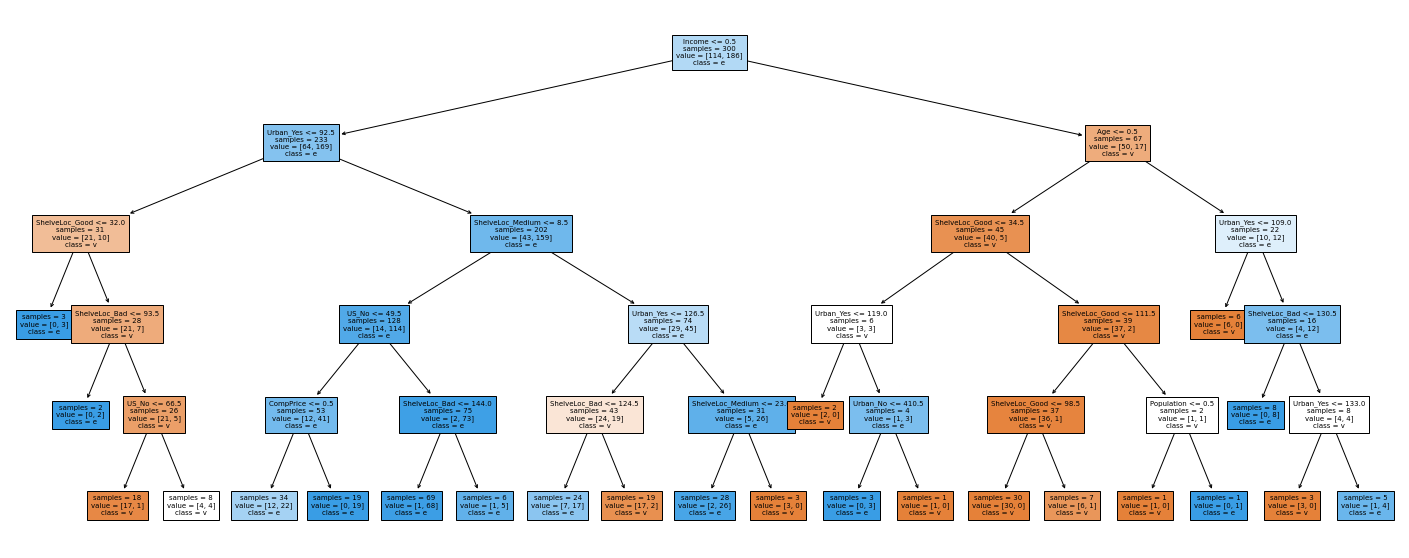

In [19]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(25, 10))
print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")
plot = plot_tree(decision_tree = modelo,
                 feature_names = labels.tolist(),
                 class_names = 'ventas_altas',
                 filled = True,
                 impurity = False,
                 fontsize = 7,
                 ax = ax)

# Predicción Y Evaluación Del Modelo


Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.


In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)
print("Matriz de confusión")
print("-------------------")
confusion_matrix(y_true = y_test,
                 y_pred = predicciones)


Matriz de confusión
-------------------


array([[29, 21],
       [ 7, 43]], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
# Acuraccy
accuracy = accuracy_score(y_true = y_test, 
                          y_pred = predicciones,
                          normalize = True)

print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 72.0 %


El modelo inicial es capaz de predecir correctamente un 72 % de las observaciones del conjunto de
test.


# Podado el Árbol (Prunning)

Aunque inicialmente se ha empleado un valor de max_depth=5 , este no tiene por qué ser el mejor valor. Con el objetivo de identificar la profundidad óptima que consigue reducir la varianza y aumentar la capacidad predictiva del modelo, se somete al árbol a un proceso de pruning.

In [24]:
from sklearn.model_selection import GridSearchCV

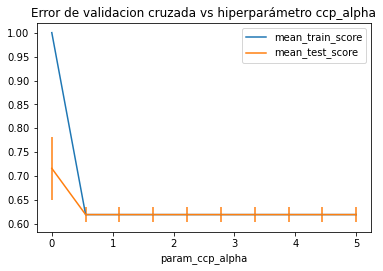

In [25]:
 # Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}
# Búsqueda por validación cruzada
grid = GridSearchCV(
    # El árbol se crece al máximo posible antes de aplicar el pruning
    estimator = DecisionTreeClassifier(max_depth = None,
                                       min_samples_split = 2,
                                       min_samples_leaf = 1,
                                       random_state = 123),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 10,
    refit = True,
    return_train_score = True
)

grid.fit(X_train_prep, y_train)
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [26]:
 # Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0}

Por default el criterio es GINI, en otro caso se indica el de entropía.  
Una vez identificado el valor óptimo de ccp_alpha , se reentrena el árbol indicando este valor en sus argumentos. Si en el GridSearchCV() se indica refit=True , este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_ .

In [27]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 9
Número de nodos terminales: 49


In [28]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)
accuracy = accuracy_score(y_true = y_test,
                          y_pred = predicciones,
                          normalize = True)

print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 75.0 %


Gracias al proceso de pruning el porcentaje de acierto ha pasando de 72% a 75%.

# Importancia De Predictores

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el índice Gini, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.


In [29]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
 {'predictor': labels.tolist(),
 'importancia': modelo_final.feature_importances_}
 )
importancia_predictores.sort_values('importancia', ascending=False)


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
11,Urban_Yes,0.267291
7,ShelveLoc_Bad,0.173585
1,Income,0.163736
8,ShelveLoc_Good,0.093583
9,ShelveLoc_Medium,0.089938
12,US_No,0.055480
6,Education,0.039439
4,Price,0.035371
0,CompPrice,0.033437
10,Urban_No,0.024170


El predictor con más importancia es Urban_Yes.

# Predicción De Probabilidades

La mayoría de implementaciones de los modelos basados en árboles, entre ellas la de scikit-learn, permiten predicir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.  
  
En el ejemplo anterior, al aplicar .predict() se devuelve (ventas elevadas) o (ventas bajas) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con .predict_proba() , en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.



In [30]:
 # Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict_proba(X = X_test_prep)
predicciones[:5, :]


array([[1.        , 0.        ],
       [0.        , 1.        ],
       [0.89473684, 0.10526316],
       [0.94444444, 0.05555556],
       [0.89473684, 0.10526316]])

El resultado de .predict_proba() es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada classe en el nodo terminal al que ha llegado la observación predicha.  
  
Por defecto, .predict() asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.


In [31]:
 # Clasificación empleando la clase de mayor probabilidad
# ------------------------------------------------------------------------------
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,1.000000,0.000000,0
1,0.000000,1.000000,1
2,0.894737,0.105263,0


Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se prevee que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.  
  
Si se dispone de las probabilidades, se puede establecer un punto de corte concreto, por ejemplo, considerando únicamente como clase (ventas altas) aquellas tiendas cuya predicción para esta clase sea superior al 0.8 (80%). De esta forma, la clasificación final se ajusta mejor a las necesidades del caso de uso.

In [32]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ------------------------------------------------------------------------------
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.8, 1, 0)
df_predicciones.iloc[5:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
5,0.500000,0.500000,1,0
6,0.071429,0.928571,1,1
7,0.944444,0.055556,0,0
8,0.014493,0.985507,1,1
9,0.291667,0.708333,1,0


## ¿Hasta que punto se debe de confiar en estas probabilidades?  
Es muy importante tener en cuenta la diferencia entre la visión que tiene el modelo del mundo y el mundo real. Todo lo que sabe un modelo sobre el mundo real es lo que ha podido aprender de los datos de entrenamiento y, por lo tanto, tiene una visión limitada. Por ejemplo, supóngase que, en los datos de entrenamiento, todas las tiendas que están en zona urbana Urban='Yes' tienen ventas altas independientemente del valor que tomen el resto de predictores. Cuando el modelo trate de predecir una nueva observación, si esta está en zona urbana, clasificará a la tienda como ventas elevadas con un 100% de seguridad. Sin embargo, esto no significa que sea inequivocamente cierto, podría haber tiendas en zonas úrbanas que no tienen ventas elevadas pero, al no estar presentes en los datos de entrenamiento, el modelo no contempla esta posibilidad.  
  
Otro ejemplo de como estás probabilidades pueden ser engañosas es el siguiente. Si se deja crecer un árbol hasta que todas las observaciones de entrenamiento están en un nodo terminal distinto, cuando se realice una nueva predicción, independientemente del nodo en el que termine, el 100% de las observaciones (solo hay una) pertenecerán a la misma clase. Como el valor de la probabilidad es el porcentaje de observaciones que pertenecen a cada clase en el nodo terminal, el modelo predicirá siempre con un 100% de probabilidad aunque se equivoque.  
  
Teniendo en cuenta todo esto, hay que considerar las probabilidades generadas por el modelo como la seguridad que tiene este, desde su visión limitada, al realizar las predicciones. Pero no como la probailidad en el mundo real de que así lo sea.
